## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

## Load the Dataset

In [2]:
BASE_DIR = r"D:\my space\UTKFace dataset\UTKFace"

In [3]:
# labels - age, ethnicity
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23697 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

image  age
0  D:\my space\UTKFace dataset\UTKFace\100_0_0_20...  100
1  D:\my space\UTKFace dataset\UTKFace\100_0_0_20...  100
2  D:\my space\UTKFace dataset\UTKFace\100_1_0_20...  100
3  D:\my space\UTKFace dataset\UTKFace\100_1_0_20...  100
4  D:\my space\UTKFace dataset\UTKFace\100_1_0_20...  100

## Exploratory Data Analysis

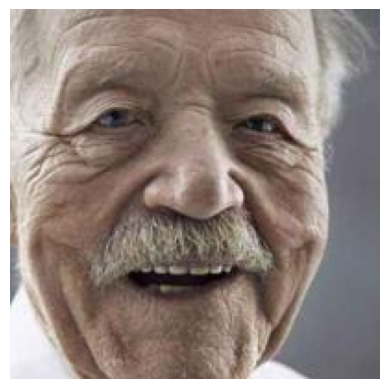

In [5]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

In [6]:
sns.distplot(df['age'])

<Axes: xlabel='age', ylabel='Density'>

In [7]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

## Feature Extraction

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128))
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [9]:
X = extract_features(df['image'])

  0%|          | 0/23697 [00:00<?, ?it/s]

In [10]:
X.shape

(23697, 128, 128, 3)

In [11]:
# normalize the images
X = X/255.0

In [12]:
y_age = np.array(df['age'])

In [13]:
input_shape = (128, 128, 3)

## Model Creation

In [14]:
inputs = Input((input_shape))

conv_1 = Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2),strides=2 ,padding='same') (conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2),strides=2 ,padding='same') (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2),strides=2 ,padding='same') (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2),strides=2 ,padding='same') (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.2)(dense_1)

output = Dense(1, activation='relu', name='age_out') (dropout_1)

model = Model(inputs=[inputs], outputs=[output])

model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_out (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,602,561 (17.56 MB)

 Trainable params: 4,602,561 (17.56 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# train model
history = model.fit(X, y_age, batch_size=16, epochs=20, validation_split=0.2)

Epoch 1/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 242s 201ms/step - loss: 11.4051 - mae: 11.4051 - mse: 226.4008 - val_loss: 31.4574 - val_mae: 31.4574 - val_mse: 1141.3234
Epoch 2/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 239s 202ms/step - loss: 8.5852 - mae: 8.5852 - mse: 129.7459 - val_loss: 28.5619 - val_mae: 28.5619 - val_mse: 1007.3285
Epoch 3/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 233s 197ms/step - loss: 7.0077 - mae: 7.0077 - mse: 92.4990 - val_loss: 26.4732 - val_mae: 26.4732 - val_mse: 900.6470
Epoch 4/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 230s 194ms/step - loss: 6.4518 - mae: 6.4518 - mse: 81.1845 - val_loss: 29.2624 - val_mae: 29.2624 - val_mse: 1125.0059
Epoch 5/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 252s 212ms/step - loss: 5.9893 - mae: 5.9893 - mse: 70.4605 - val_loss: 22.9349 - val_mae: 22.9349 - val_mse: 737.5438
Epoch 6/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 234s 198ms/step - loss: 5.7331 - mae: 5.7331 - mse: 65.0851 - val_loss: 24.3955 - val_mae: 24.3955 - val_mse: 785.7394
Epoch 7/20
1185/1185 ━━━━━━

## Plot the Results

# Prediction with Test Data

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you used 'validation_split=0.2' in model.fit()
# Get the number of samples in the validation set
num_val_samples = int(len(X))

# Extract validation predictions from the history object
# Note: You need to pass the validation data to .predict(), not the entire dataset
val_pred = model.predict(X[-num_val_samples:])  # Use the last 20% of the data as validation

# Extract validation true values (assuming y_age contains all labels)
val_true = y_age[-num_val_samples:] # Adjust index based on your validation split

# Calculate metrics
mae = mean_absolute_error(val_true, val_pred)
mse = mean_squared_error(val_true, val_pred)
r2 = r2_score(val_true, val_pred)

print(f"Validation Mean Absolute Error: {mae}")
print(f"Validation Mean Squared Error: {mse}")
print(f"Validation R-squared: {r2}")

741/741 ━━━━━━━━━━━━━━━━━━━━ 77s 104ms/step
Validation Mean Absolute Error: 6.441190267648507
Validation Mean Squared Error: 132.896132860234
Validation R-squared: 0.6637397631510229


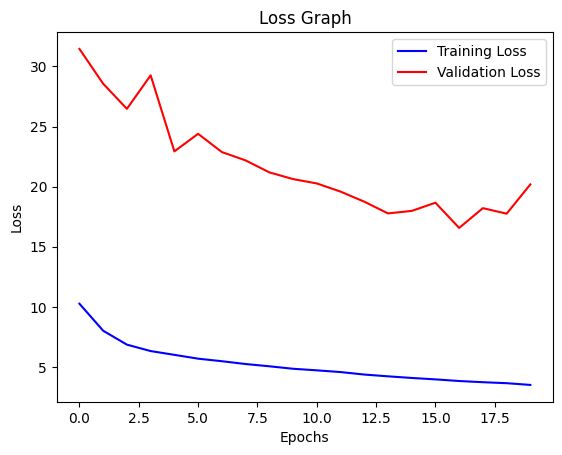

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plotting the training and validation loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Age: 6


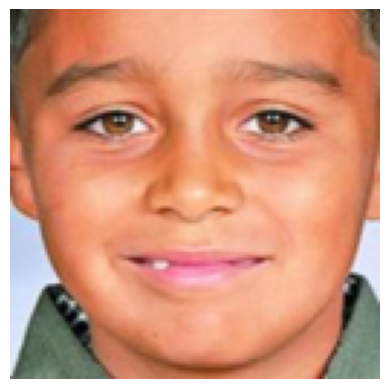

In [43]:
image_index = 103
print( "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128,3), cmap='gray');

In [44]:
image_index = 3000
print( "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_age = round(pred[0][0])
print( "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128,3), cmap='gray');

Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Age: 19


In [45]:
image_index = 9778
print( "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128,3), cmap='gray');

Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Age: 28


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Age: 29


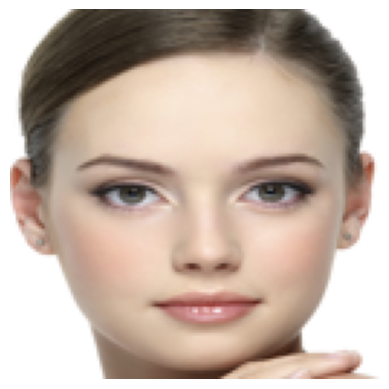

In [46]:
from PIL import Image

# Read the image using an absolute file path
test_img = Image.open('D:\\my space\\UTKFace dataset\\test_img_1.png') #path of your testing image 

# Check if the image was loaded successfully
if test_img is None:
    print("Error: Could not read the image. Check the file path.")
else:
    # Convert the image to RGB (if it's not already in that mode)
    test_img = test_img.convert('RGB')
    
    # Resize the image to 128x128
    test_img = test_img.resize((128, 128))
    
    # Convert the image to a NumPy array
    test_img_array = np.array(test_img)
    
    # Normalize the image array (if your model expects normalized input)
    test_img_array = test_img_array / 255.0
    
    # Predict the age
    pred = model.predict(test_img_array.reshape(1, 128, 128, 3))
    pred_age = round(pred[0][0])
    
    # Print the predicted age
    print("Predicted Age:", pred_age)
    
    # Display the image
    plt.axis('off')
    plt.imshow(test_img_array)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Age: 25


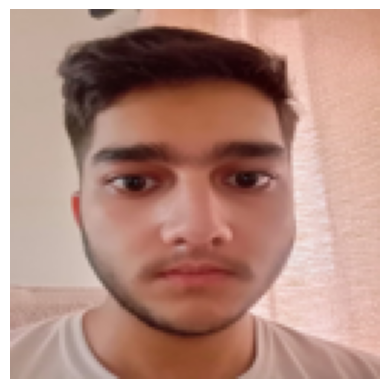

In [31]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your model (replace 'path_to_model' with the actual path to your model file)
# Example: model = tf.keras.models.load_model('path_to_model')
# model = ...

# Image file path
image_path = r"D:\my space\UTKFace dataset\test_img_3.jpeg" #path of your testing image

try:
    # Read the image
    test_img = Image.open(image_path)

    # Convert the image to RGB (if it's not already in that mode)
    test_img = test_img.convert('RGB')
    
    # Resize the image to 128x128
    test_img = test_img.resize((128, 128))
    
    # Convert the image to a NumPy array
    test_img_array = np.array(test_img)
    
    # Normalize the image array (if your model expects normalized input)
    test_img_array = test_img_array / 255.0
    
    # Predict the age
    pred = model.predict(test_img_array.reshape(1, 128, 128, 3))
    pred_age = round(pred[0][0])
    
    # Print the predicted age
    print("Predicted Age:", pred_age)
    
    # Display the image
    plt.axis('off')
    plt.imshow(test_img_array)
    plt.show()

except Exception as e:
    print(f"Error: {e}")
